In [90]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import csv
import re
from simplemma import text_lemmatizer
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [15]:
url_Ürünler = [
    "https://www.arabam.com/ikinci-el/otomobil?page=",
    "https://www.arabam.com/ikinci-el/motosiklet?page=",
    "https://www.arabam.com/ikinci-el/arazi-suv-pick-up?page",
    "https://www.arabam.com/ikinci-el/minivan-van_panelvan?page",
]

markalar = []
modeller = []
veri = []

link_basi = "https://www.arabam.com/"

for urlm in url_Ürünler:
    url_template = urlm + "{page_number}"

    for page_number in range(1, 50):
        url = url_template.format(page_number=page_number)
        page = requests.get(url)
        html = BeautifulSoup(page.content, "html.parser")

        main_page = html.find("div", class_="df row")
        
        arabalar = main_page.find_all("tr", class_="listing-list-item pr should-hover bg-white")
        
        # araba modeli
        models = html.find_all("div", class_="listing-text-new word-break val-middle color-black2018")
        for j in models:
            model = j.text.strip()
            modeller.append(model)

        for araba in arabalar:
            div_poster = araba.find("div", class_="pr10 fade-out-content-wrapper")
            a = div_poster.find("a")
            link_sonu = a.get("href")
            link = link_basi + link_sonu

            # araba sayfasına giriş
            araba_sayfasi = requests.get(link)
            araba_soup = BeautifulSoup(araba_sayfasi.content, "html.parser")

            # araba markası
            markas = araba_soup.select("div.property-value")[2]
            for i in markas:
                marka = i.text.strip()
                if not marka.isdigit():
                    markalar.append(marka)

csv_file_path = "araba.csv"

with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Model", "Marka"])
    for i in range(len(markalar)):
        veri.append([modeller[i], markalar[i]])
        writer.writerow(veri[i])

In [16]:
df = pd.read_csv("araba.csv")
df.head(-5)

,Model,Marka
0,Renault Symbol 1.5 dCi Joy,Renault
1,Renault Megane 1.5 dCi Privilege,Renault
2,Fiat Linea 1.3 Multijet Active Plus,Fiat
3,Ford Fiesta 1.4 TDCi Comfort,Ford
4,Fiat Palio 1.2 HL,Fiat
...,...,...
3885,Peugeot Partner 1.9 D Comfort,Volkswagen
3886,Fiat Doblo Combi 1.6 Multijet Premio Plus,Volkswagen
3887,Peugeot Rifter 1.5 BlueHDI Allure,Ford
3888,Fiat Fiorino Combi 1.3 Multijet Pop,Fiat


In [17]:
stop_words = None
with open("stopwords.txt", "r") as stop_file:
    stop_words = set(stop_file.read().splitlines())

def clean(text):
    text = text.replace("Â", "a")
    text = text.replace("â", "a")
    text = text.replace("î", "i")
    text = text.replace("Î", "ı")
    text = text.replace("İ", "i")
    text = text.replace("I", "ı")
    text = text.replace(u"\u00A0", " ")
    text = text.replace("|", " ")

    text = re.sub(r"@[A-Za-z0-9]+", " ", text)
    text = re.sub(r"(.)\1+", r"\1\1", text)
    text = re.sub(r"https?:\/\/\S+", " ", text)
    text = re.sub(r"http?:\/\/\S+", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"#(\w+)", " ", text)
    text = re.sub(r"^\x00-\x7F]+", " ", text)
    text = re.sub(r"[^A-Za-zâîığüşöçİĞÜŞÖÇ]+", " ", text)
    text = re.sub(r"((https://[^\s]+))", " ", text)

    text = " ".join(text.lower().strip().split())
    text = text_lemmatizer(text, lang="tr")

    return " ".join([word for word in text if word not in stop_words])

In [18]:
# temizleme ve etiketleme
df["Temiz"] = df.apply(lambda row: clean(row["Model"]), axis=1)

# arabaları kategorilerine göre etiketleme
kategoriler = []

for i in markalar:
    if i not in kategoriler:
        kategoriler.append(i)

def etiketle(row):   
     for key, i in enumerate(kategoriler):
        if row["Marka"] == i:
            return int(key)
        
df["Etiket"] = df.apply(lambda row:  etiketle(row), axis=1)

# kategori == ""
df["Etiket"].replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# bazen etiket float oluyordu bu kodla çözüldü
df["Etiket"] = df["Etiket"].astype(int)

df.to_csv("arabaModel.csv", index=False)

In [12]:
df = pd.read_csv("arabaModel.csv")
df.head(-5) 

,Model,Marka,Temiz,Etiket
0,Renault Symbol 1.5 dCi Joy,Renault,renault symbol dci joy,0
1,Renault Megane 1.5 dCi Privilege,Renault,renault megane dci privilege,0
2,Fiat Linea 1.3 Multijet Active Plus,Fiat,fiat linea multijet active plus,1
3,Ford Fiesta 1.4 TDCi Comfort,Ford,ford fiesta tdci comfort,2
4,Fiat Palio 1.2 HL,Fiat,fiat palio hl,1
...,...,...,...,...
69,Volkswagen Caravelle 2.0 TDI Trendline,Volkswagen,volkswagen caravel tdı trend,6
70,Volkswagen Caddy 2.0 TDI Comfortline,Volkswagen,volkswagen caddy tdı comfortline,6
71,Ford Tourneo Connect 1.5 EcoBlue Deluxe,Ford,ford tourneo connect ecoblue deluxe,2
72,Fiat Doblo Combi 1.6 Multijet Elegance,Fiat,fiat doblo combi multijet elegance,1


In [19]:
# araba markalarının ve modellerinin veri setindeki sayısını bulma
marka_turleri = {}

for i in markalar:
    if i not in marka_turleri:
        marka_turleri[i] = 1
    else:
        marka_turleri[i] += 1

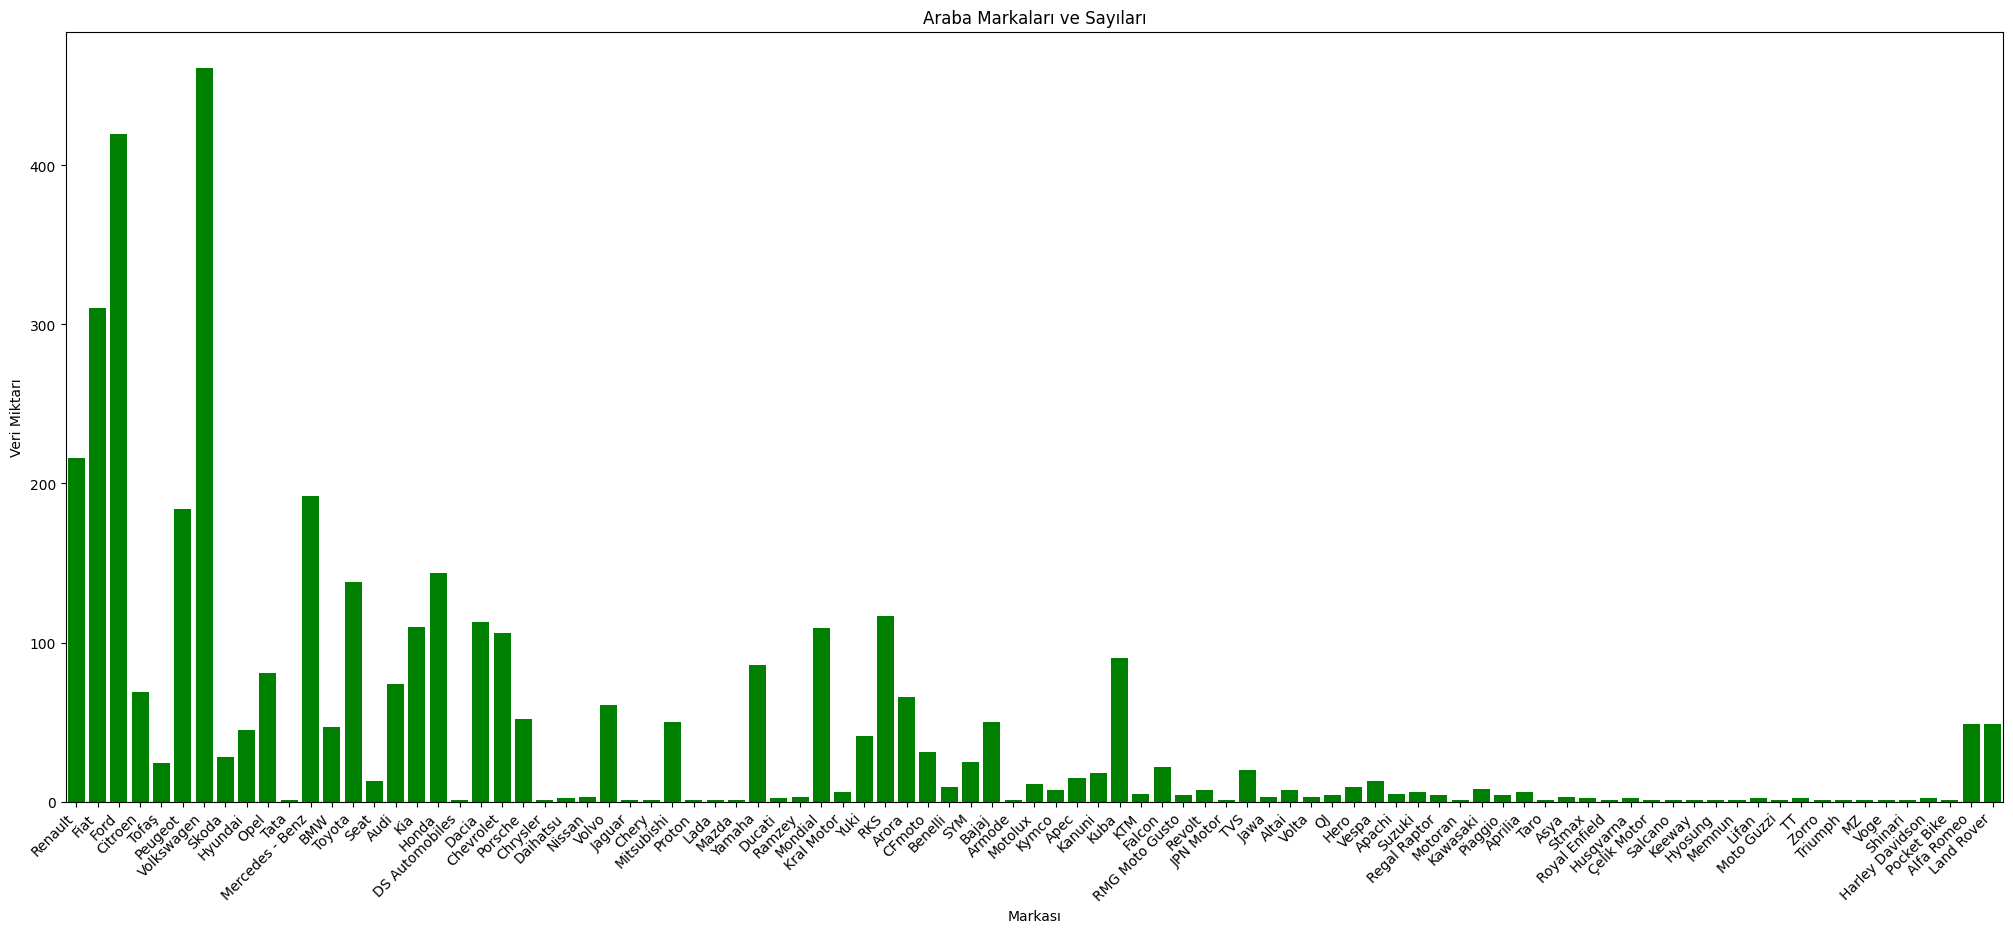

In [46]:
df = pd.DataFrame({"Markalar": list(marka_turleri.keys()), "Veri Miktarı": list(marka_turleri.values())})

# grafik boyutu ayarlama 
fig, ax = plt.subplots(figsize=(25, 10))

# grafik çizimi
ax.bar(df["Markalar"], df["Veri Miktarı"], color="green")

# x ekseninde markalar üst üste yazılıyordu onun için markaları döndürerek düzelttim
plt.xticks(range(len(df["Markalar"])), df["Markalar"], rotation=45, ha="right")

# x ekseninde markalar arası boşluğu düşürdüm
plt.xlim(-0.5, len(df["Markalar"]) - 0.5)

plt.title("Araba Markaları ve Sayıları")
plt.xlabel("Markası")
plt.ylabel("Veri Miktarı")
plt.show()

In [47]:
# model eğitimi için gerekli sutünların alınması
df = pd.read_csv("arabaModel.csv")

X = df["Temiz"].to_numpy()
y = df["Etiket"].to_numpy()

print(len(X), len(y))

3895 3895


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# vektörleştirme
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [106]:
# Decision Tree ile model eğitimi 
clf = DecisionTreeClassifier()
clf.fit(X_train_tfidf, y_train)

DecisionTreeClassifier()

In [107]:
# modelin başarı oranı
clf.score(X_test_tfidf, y_test)

0.72400513478819

In [99]:
# dışarıdan girilen girdi için marka tahmini
yeni_metin = "2005 Kasa Kazalı Boyasız Kia"
yeni_metin_tfidf = vectorizer.transform([yeni_metin])
tahmin_indeks = clf.predict(yeni_metin_tfidf.toarray())[0]
tahmin_edilen_marka = kategoriler[tahmin_indeks]
print(tahmin_edilen_marka)

Kia
